In [17]:
!pip install ta --upgrade

In [18]:
import pandas as pd
csv_path = "/content/nifty_500.csv"
df = pd.read_csv(csv_path)
# print(df) # Keep for debugging if needed

# Extract symbols from the 'Symbol' column
# Handle potential missing values and remove leading/trailing whitespace
symbols_list = df['Symbol'].dropna().astype(str).str.strip().tolist()

# Add ".NS" to each symbol for compatibility with yfinance
symbols_list = [symbol + ".NS" for symbol in symbols_list]


# Optional: Print the list of symbols to verify
print("List of symbols extracted:")
print(symbols_list[:10]) # Print first 10 symbols as a sample
print(f"Total number of symbols: {len(symbols_list)}")

List of symbols extracted:
['3MINDIA.NS', 'AARTIDRUGS.NS', 'AAVAS.NS', 'ABB.NS', 'ABBOTINDIA.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABSLAMC.NS', 'ACC.NS', 'ADANIENT.NS']
Total number of symbols: 501


In [24]:
import math
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
# from ta.volume import OnBalanceVolume # Removed problematic import
import warnings
import os

warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
DATA_DIR = "/content/stock_data" # Directory to save downloaded data
STARTING_CAPITAL = 25_00_000.0      # INR 25,00,000
RISK_PCT = 0.004                    # 0.4% of CURRENT total capital per entry
YEARS = 4 # Commented out as specific dates are provided
END_DATE = pd.Timestamp.today().normalize()
START_DATE = END_DATE - pd.DateOffset(years=YEARS)


ADX_PERIOD = 14
ATR_PERIOD = 14
DMA_FAST = 20
DMA_SLOW = 50
DMA_HIT_TOL = 0.005   # touch tolerance = 0.5% of DMA
OBV_MA_PERIOD = 20 # New: period for OBV moving average
# Ensure enough rows for all indicator calculations
MIN_ROWS = max(DMA_SLOW, ADX_PERIOD, OBV_MA_PERIOD) + 1 # Add 1 because rolling window includes current day

OUT_TRADES_CSV = "nifty_backtest_trades.csv"
OUT_SUMMARY_CSV = "nifty_backtest_summary.csv"
MAX_OPEN_POSITIONS = 250 # New: Maximum number of open positions

# New: Risk-reward constants used in screener for estimation and potentially backtest
ATR_MULTIPLIER = 1.5
MIN_RISK_REWARD = 1.5

def fetch_and_save_price_data(ticker, start=START_DATE, end=END_DATE, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, f"{ticker}.csv")
    if os.path.exists(filepath):
        # Load existing data if available
        try:
            df = pd.read_csv(filepath, parse_dates=['Date'])
            if not df.empty and 'Date' in df.columns:
                 # Check if data is up to date and covers the required period
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.set_index('Date')
                if df.index.min().date() <= start.date() and df.index.max().date() >= end.date():
                     return df
        except Exception as e:
            print(f"Error loading data for {ticker} from {filepath}: {e}")
            pass # redownload if loading fails or data is insufficient

    try:
        df = yf.download(ticker, start=start.strftime("%Y-%m-%d"), end=(end + pd.Timedelta(days=1)).strftime("%Y-%m-%d"), progress=False, auto_adjust=False)
        if df.empty:
            print(f"No data downloaded for {ticker}")
            return None
        # ensure required columns and reset index to ensure a DatetimeIndex
        df = df[['Open','High','Low','Close','Volume']].dropna()
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        # Save to CSV with Date as a column
        os.makedirs(data_dir, exist_ok=True)
        df.reset_index(inplace=True)
        df.to_csv(filepath, index=False)
        df = df.set_index('Date')
        return df
    except Exception as e:
        print("Download error", ticker, e)
        return None

def load_price_data(ticker, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, f"{ticker}.csv")
    if not os.path.exists(filepath):
        return None
    try:
        # Skip the first row which contains the extra header
        df = pd.read_csv(filepath, parse_dates=['Date'], skiprows=[1])
        if not df.empty and 'Date' in df.columns:
            df = df.set_index('Date')
            # Rename columns to remove 'Ticker' level if it exists
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.droplevel(level=1)
            return df
        else:
            return None
    except Exception as e:
        print(f"Error loading data for {ticker} from {filepath}: {e}")
        return None

# Manual OBV Calculation
def calculate_obv(df):
    obv = [0] * len(df)
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            obv[i] = obv[i-1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            obv[i] = obv[i-1] - df['Volume'].iloc[i]
        else:
            obv[i] = obv[i-1]
    return pd.Series(obv, index=df.index)

def compute_indicators(df):
    df = df.copy()
    # Debugging: Print index type
    print(f"Index type in compute_indicators: {type(df.index)}")
    # Ensure DataFrame has a valid index before computing indicators
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Input DataFrame to compute_indicators must have a DatetimeIndex")

    try:
        df['dma20'] = df['Close'].rolling(window=DMA_FAST).mean()
        df['dma50'] = df['Close'].rolling(window=DMA_SLOW).mean()
        atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=ATR_PERIOD)
        df['atr'] = atr.average_true_range()
        adx_indicator = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=ADX_PERIOD)
        df['adx'] = adx_indicator.adx()
        df['+di'] = adx_indicator.adx_pos()  # Calculate +DI
        df['-di'] = adx_indicator.adx_neg()  # Calculate -DI

        # New: Compute On-Balance Volume manually and its moving average
        df['obv'] = calculate_obv(df) # Uncommented OBV calculation
        df['obv_ma20'] = df['obv'].rolling(window=OBV_MA_PERIOD).mean() # Uncommented OBV MA calculation
    except Exception as e:
        print(f"Error computing indicators: {e}")
        raise e # Re-raise the exception after printing

    return df

def touch_dma(close, dma):
    if pd.isna(dma) or pd.isna(close):
        return False
    return abs(close - dma) <= (DMA_HIT_TOL * dma)

In [25]:

print("Tickers loaded:", len(symbols_list))

# First, download and save all data
print("Downloading and saving price data...")
downloaded_symbols_list = []
for sym in tqdm(symbols_list, desc="Downloading"):
    df = fetch_and_save_price_data(sym)
    if df is not None and df.shape[0] >= MIN_ROWS:
        downloaded_symbols_list.append(sym)

print(f"Successfully downloaded data for {len(downloaded_symbols_list)} symbols_list.")



Tickers loaded: 501


Downloading:   2%|▏         | 12/501 [00:01<01:10,  6.92it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ADANITRANS.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:   3%|▎         | 14/501 [00:02<01:16,  6.40it/s]

No data downloaded for ADANITRANS.NS


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AEGISCHEM.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:   3%|▎         | 16/501 [00:02<01:22,  5.89it/s]

No data downloaded for AEGISCHEM.NS


Downloading:   4%|▍         | 22/501 [00:03<01:45,  4.56it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMARAJABAT.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:   5%|▍         | 24/501 [00:04<01:34,  5.03it/s]

No data downloaded for AMARAJABAT.NS


Downloading:  18%|█▊        | 88/501 [00:18<01:29,  4.62it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CENTURYTEX.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  18%|█▊        | 90/501 [00:19<01:32,  4.46it/s]

No data downloaded for CENTURYTEX.NS


Downloading:  32%|███▏      | 160/501 [00:32<00:56,  6.01it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GLS.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  32%|███▏      | 162/501 [00:32<00:52,  6.42it/s]

No data downloaded for GLS.NS


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GMRINFRA.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  33%|███▎      | 164/501 [00:33<00:56,  5.92it/s]

No data downloaded for GMRINFRA.NS


Downloading:  37%|███▋      | 186/501 [00:36<00:48,  6.53it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  38%|███▊      | 188/501 [00:36<00:47,  6.57it/s]

No data downloaded for HDFC.NS


Downloading:  41%|████      | 206/501 [00:39<00:49,  5.90it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IBULHSGFIN.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  41%|████▏     | 207/501 [00:39<00:51,  5.75it/s]

No data downloaded for IBULHSGFIN.NS


Downloading:  43%|████▎     | 213/501 [00:41<00:49,  5.80it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IDFC.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  43%|████▎     | 215/501 [00:41<00:47,  5.98it/s]

No data downloaded for IDFC.NS


Downloading:  44%|████▎     | 219/501 [00:41<00:46,  6.02it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IIFLWAM.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  44%|████▍     | 220/501 [00:42<00:46,  6.05it/s]

No data downloaded for IIFLWAM.NS


Downloading:  52%|█████▏    | 259/501 [00:48<00:39,  6.17it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KALPATPOWR.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  52%|█████▏    | 261/501 [00:48<00:35,  6.67it/s]

No data downloaded for KALPATPOWR.NS


Downloading:  54%|█████▍    | 271/501 [00:50<00:38,  6.03it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['L&TFH.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  54%|█████▍    | 273/501 [00:50<00:38,  5.95it/s]

No data downloaded for L&TFH.NS


Downloading:  55%|█████▍    | 275/501 [00:50<00:34,  6.57it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LAXMIMACH.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  55%|█████▌    | 277/501 [00:51<00:35,  6.36it/s]

No data downloaded for LAXMIMACH.NS


Downloading:  56%|█████▌    | 280/501 [00:51<00:35,  6.25it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LTI.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  56%|█████▋    | 282/501 [00:51<00:35,  6.18it/s]

No data downloaded for LTI.NS


Downloading:  57%|█████▋    | 288/501 [00:53<00:38,  5.58it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MAHINDCIE.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  58%|█████▊    | 290/501 [00:53<00:36,  5.85it/s]

No data downloaded for MAHINDCIE.NS


Downloading:  59%|█████▉    | 297/501 [00:54<00:31,  6.43it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MCDOWELL-N.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  60%|█████▉    | 299/501 [00:54<00:32,  6.13it/s]

No data downloaded for MCDOWELL-N.NS


Downloading:  61%|██████    | 305/501 [00:55<00:27,  7.20it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MINDAIND.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  61%|██████    | 306/501 [00:55<00:27,  7.00it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MINDTREE.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  61%|██████▏   | 307/501 [00:55<00:28,  6.71it/s]

No data downloaded for MINDAIND.NS
No data downloaded for MINDTREE.NS


Downloading:  73%|███████▎  | 368/501 [01:06<00:27,  4.80it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PVR.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  74%|███████▎  | 369/501 [01:08<01:21,  1.62it/s]

No data downloaded for PVR.NS


Downloading:  81%|████████  | 404/501 [01:16<00:15,  6.28it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SHRIRAMCIT.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  81%|████████  | 406/501 [01:17<00:16,  5.88it/s]

No data downloaded for SHRIRAMCIT.NS


Downloading:  83%|████████▎ | 418/501 [01:19<00:14,  5.56it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SRTRANSFIN.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  84%|████████▍ | 420/501 [01:19<00:13,  5.89it/s]

No data downloaded for SRTRANSFIN.NS


Downloading:  86%|████████▌ | 431/501 [01:21<00:14,  4.86it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SUVENPHAR.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  86%|████████▋ | 433/501 [01:22<00:12,  5.66it/s]

No data downloaded for SUVENPHAR.NS


Downloading:  89%|████████▊ | 444/501 [01:23<00:09,  5.76it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TATAMTRDVR.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  89%|████████▉ | 446/501 [01:24<00:09,  5.80it/s]

No data downloaded for TATAMTRDVR.NS


Downloading:  89%|████████▉ | 447/501 [01:24<00:10,  4.99it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TATASTLLP.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  90%|████████▉ | 449/501 [01:24<00:09,  5.44it/s]

No data downloaded for TATASTLLP.NS


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TCNSBRANDS.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  90%|█████████ | 451/501 [01:25<00:08,  5.68it/s]

No data downloaded for TCNSBRANDS.NS


Downloading:  93%|█████████▎| 466/501 [01:27<00:05,  6.42it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TV18BRDCST.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  93%|█████████▎| 468/501 [01:27<00:04,  8.02it/s]

No data downloaded for TV18BRDCST.NS


Downloading:  98%|█████████▊| 489/501 [01:31<00:02,  5.21it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WELSPUNIND.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  98%|█████████▊| 491/501 [01:31<00:01,  6.76it/s]

No data downloaded for WELSPUNIND.NS


Downloading:  99%|█████████▉| 498/501 [01:32<00:00,  5.99it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZOMATO.NS']: YFTzMissingError('possibly delisted; no timezone found')
Downloading: 100%|█████████▉| 500/501 [01:32<00:00,  7.23it/s]

No data downloaded for ZOMATO.NS


Downloading: 100%|██████████| 501/501 [01:33<00:00,  5.38it/s]

Successfully downloaded data for 471 symbols_list.


In [26]:
# backtest_symbol function modified to only generate trade signals
def backtest_symbol(df, symbol):
    trades = []   # record per-exit trade logs
    entries = []  # open entries: list of dicts {entry_price, entry_date, entry_type}
    # We allow up to 2 entries per symbol per life-cycle (20dma entry + possible 50dma add)
    for idx in range(len(df)):
        date = df.index[idx]
        row = df.iloc[idx]
        # skip until enough data for all indicators
        if idx < MIN_ROWS:
            continue
        price = row['Close']
        adx = row['adx']
        plus_di = row['+di']  # Get +DI
        minus_di = row['-di'] # Get -DI
        dma20 = row['dma20']
        dma50 = row['dma50']
        atr = row['atr']
        obv = row['obv'] # Get OBV
        obv_ma20 = row['obv_ma20'] # Get OBV MA20


        if any(pd.isna(x) for x in [price, adx, plus_di, minus_di, dma20, dma50, atr, obv, obv_ma20]): # Add +DI, -DI, OBV and OBV MA to check
            continue

        # compute the SL level for the current day (50dma - ATR)
        sl_level = dma50 - atr

        # ---------- check stop loss first ----------
        if entries:
            # If today's close breaches SL -> exit all entries at today's close
            if price <= sl_level:
                # Record each entry's exit
                for e in entries:
                    trades.append({
                        'symbol': symbol,
                        'entry_date': e['entry_date'],
                        'entry_price': e['entry_price'],
                        'exit_date': date,
                        'exit_price': price,
                        'reason': 'SL',
                        'entry_type': e['entry_type'],
                        'atr': atr, # Include ATR in trade signal
                        'entry_adx': e['entry_adx'], # Include ADX at entry
                        'entry_dma50': e['entry_dma50'], # Include DMA50 at entry
                        'risk_percentage': e.get('risk_percentage') # Include risk percentage at entry
                    })
                entries = []
                # continue to next day
                continue

            # check DMA cross: if previously dma20 > dma50 and now dma20 < dma50 => trend flipped => exit
            if idx >= 1:
                prev = df.iloc[idx-1]
                prev_dma20 = prev['dma20']; prev_dma50 = prev['dma50']
                if prev_dma20 > prev_dma50 and dma20 < dma50:
                    # exit all at today's close
                    for e in entries:
                        trades.append({
                            'symbol': symbol,
                            'entry_date': e['entry_date'],
                            'entry_price': e['entry_price'],
                            'exit_date': date,
                            'exit_price': price,
                            'reason': 'DMA_CROSS',
                            'entry_type': e['entry_type'],
                            'atr': atr, # Include ATR in trade signal
                            'entry_adx': e['entry_adx'], # Include ADX at entry
                            'entry_dma50': e['entry_dma50'], # Include DMA50 at entry
                            'risk_percentage': e.get('risk_percentage') # Include risk percentage at entry
                        })
                    entries = []
                    continue


        # ---------- no open entries: consider entry at 20DMA ----------
        if not entries:
            # require ADX > 25 and upward trend (dma20 > dma50) AND price touches 20dma AND OBV > OBV_MA20 AND +DI > -DI
            if adx > 25 and dma20 > dma50 and touch_dma(price, dma20) and obv > obv_ma20 and plus_di > minus_di:
                # Calculate risk percentage
                # Ensure atr and dma50 are not None or zero before calculating risk percentage
                if atr is not None and atr > 0 and dma50 is not None and dma50 > 0 and price is not None and price > 0:
                    # Calculate estimated stop loss and risk per share at entry using the new formula
                    estimated_stop_loss = dma50 - (atr * ATR_MULTIPLIER)  # Use ATR_MULTIPLIER from config
                    estimated_risk_per_share = price - estimated_stop_loss

                    # Ensure estimated_risk_per_share is positive for meaningful Risk %
                    if estimated_risk_per_share > 0:
                        risk_percentage = (estimated_risk_per_share / price) * 100
                        # Check risk percentage condition
                        if risk_percentage < 10: # Use 10% as the threshold
                             # open first entry
                            entries.append({
                                'entry_price': price,
                                'entry_date': date,
                                'entry_type': '20dma',
                                'entry_adx': adx, # Record ADX at entry
                                'entry_dma50': dma50, # Record DMA50 at entry
                                'risk_percentage': risk_percentage # Record calculated risk percentage
                            })
                            continue


        # ---------- if have one entry already, allow pyramid at 50DMA ----------
        if entries and len(entries) == 1:
            # require ADX > 25 and same upward trend AND price touches 50dma AND OBV > OBV_MA20 AND +DI > -DI
            if adx > 25 and dma20 > dma50 and price < dma50 and obv > obv_ma20 and plus_di > minus_di:
                # Calculate risk percentage for the potential pyramid entry
                # Ensure atr and dma50 are not None or zero before calculating risk percentage
                if atr is not None and atr > 0 and dma50 is not None and dma50 > 0 and price is not None and price > 0:
                    # Calculate estimated stop loss and risk per share at entry using the new formula
                    estimated_stop_loss = dma50 - (atr * ATR_MULTIPLIER) # Use ATR_MULTIPLIER from config
                    estimated_risk_per_share = price - estimated_stop_loss

                     # Ensure estimated_risk_per_share is positive for meaningful Risk %
                    if estimated_risk_per_share > 0:
                        risk_percentage = (estimated_risk_per_share / price) * 100
                        # Check risk percentage condition
                        if risk_percentage < 10: # Use 10% as the threshold
                            entries.append({
                                'entry_price': price,
                                'entry_date': date,
                                'entry_type': '50dma',
                                'entry_adx': adx, # Record ADX at entry
                                'entry_dma50': dma50, # Record DMA50 at entry
                                'risk_percentage': risk_percentage # Record calculated risk percentage
                            })
                            continue

    # ------------- end loop days: if any entries remain, close at last close -------------
    if entries:
        last_row = df.iloc[-1]
        last_price = last_row['Close']
        last_adx = last_row['adx'] # Get last ADX
        last_dma50 = last_row['dma50'] # Get last DMA50
        for e in entries:
            trades.append({
                'symbol': symbol,
                'entry_date': e['entry_date'],
                'entry_price': e['entry_price'],
                'exit_date': df.index[-1],
                'exit_price': last_price,
                'reason': 'END',
                'entry_type': e['entry_type'],
                'atr': atr, # Include ATR in trade signal (this will be the ATR of the last day)
                'entry_adx': e['entry_adx'], # Include ADX at entry
                'entry_dma50': e['entry_dma50'], # Include DMA50 at entry
                'risk_percentage': e.get('risk_percentage') # Include risk percentage at entry
            })
        entries = []

    # Check for duplicate entries in the 'trades' list
    seen = set()
    duplicates = []
    for trade in trades:
        # Create a tuple of the trade's key attributes to check for duplicates
        trade_key = (trade['symbol'], trade['entry_date'], trade['entry_price'], trade['exit_date'], trade['exit_price'], trade['reason'], trade['entry_type']) # Removed dma50 from key as it's not always present for all exit reasons
        if trade_key in seen:
            duplicates.append(trade)
        else:
            seen.add(trade_key)

    if duplicates:
        print(f"Duplicate trade entries found for {symbol}:")
        for dup in duplicates:
            print(dup)

    # Return the list of trade signals
    return trades

In [27]:
# Collect all potential trade signals from backtest_symbol
all_trade_signals = []

print("Collecting trade signals using saved data...")
for sym in tqdm(downloaded_symbols_list, desc="Collecting Signals"):
    df = load_price_data(sym)
    if df is None or df.shape[0] < MIN_ROWS:
        print(f"Skipping {sym} due to insufficient data after loading.")
        continue

    try:
        df = compute_indicators(df)
        df.attrs['symbol'] = sym
        # Call backtest_symbol to get potential trade signals
        trade_signals = backtest_symbol(df, sym)

        # Append signals from this symbol
        for t in trade_signals:
            all_trade_signals.append(t)

    except ValueError as e:
        print(f"Skipping symbol {sym} due to error during indicator computation: {e}")
        continue
    except Exception as e:
        print(f"An unexpected error occurred for symbol {sym}: {e}")
        continue

all_trade_signals_df = pd.DataFrame(all_trade_signals)

# Display the DataFrame
display(all_trade_signals_df)

# Remove duplicate trade signals before simulating
print("Removing duplicate trade signals...")
seen_signals = set()
unique_trade_signals = []
for signal in all_trade_signals:
    # Create a unique key for each signal based on relevant attributes
    signal_key = (signal['symbol'], signal['entry_date'], signal['entry_price'], signal['exit_date'], signal['exit_price'], signal['reason'], signal['entry_type'])
    if signal_key not in seen_signals:
        unique_trade_signals.append(signal)
        seen_signals.add(signal_key)
    # Optional: Print detected duplicates
    # else:
    #     print(f"Detected duplicate signal: {signal}")

print(f"Original number of signals: {len(all_trade_signals)}")
print(f"Number of unique signals: {len(unique_trade_signals)}")

Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Index type in compute_indicators: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,symbol,entry_date,entry_price,exit_date,exit_price,reason,entry_type,atr,entry_adx,entry_dma50,risk_percentage
0,3MINDIA.NS,2022-06-21,19987.400391,2022-10-27,22610.300781,SL,20dma,690.916497,26.899117,19697.283789,6.837375
1,3MINDIA.NS,2023-07-26,27955.750000,2023-10-23,29390.050781,SL,20dma,752.326712,25.402900,26761.157930,8.059326
2,3MINDIA.NS,2025-05-06,29640.000000,2025-06-18,29175.000000,DMA_CROSS,20dma,582.702595,28.898850,28346.774063,8.511199
3,AARTIDRUGS.NS,2022-07-27,419.299988,2022-11-23,452.500000,SL,20dma,11.200931,27.617727,416.759000,5.461441
4,AARTIDRUGS.NS,2023-06-21,458.049988,2023-09-26,548.400024,SL,20dma,20.317369,37.373740,446.598000,7.440495
...,...,...,...,...,...,...,...,...,...,...,...
1149,ZYDUSWELL.NS,2023-09-08,320.459991,2023-10-16,312.230011,DMA_CROSS,20dma,5.845193,36.271789,305.220001,8.542129
1150,ZYDUSWELL.NS,2024-01-11,328.619995,2024-02-13,313.929993,SL,20dma,7.509693,31.598665,316.114799,6.962748
1151,ZYDUSWELL.NS,2024-06-03,344.910004,2024-09-17,433.989990,SL,20dma,12.644496,37.924001,327.302401,9.526784
1152,ZYDUSWELL.NS,2024-12-13,402.390015,2025-01-09,390.410004,DMA_CROSS,20dma,10.866398,26.896038,391.046600,7.530013


Removing duplicate trade signals...
Original number of signals: 1154
Number of unique signals: 1154


In [28]:
average_risk_percentage = all_trade_signals_df['risk_percentage'].mean()
print(f"The average risk percentage in all_trade_signals_df is: {average_risk_percentage:.2f}%")

The average risk percentage in all_trade_signals_df is: 7.43%


In [29]:
import math
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
import warnings
import os

warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
DATA_DIR = "/content/stock_data" # Directory to save downloaded data
STARTING_CAPITAL = 25_00_000.0      # INR 25,00,000
RISK_PCT = 0.005                    # 0.5% of CURRENT total capital per entry
YEARS = 3
END_DATE = pd.Timestamp.today().normalize()
START_DATE = END_DATE - pd.DateOffset(years=YEARS)

ADX_PERIOD = 14
ATR_PERIOD = 14
DMA_FAST = 20
DMA_SLOW = 50
DMA_HIT_TOL = 0.005   # touch tolerance = 0.5% of DMA
OBV_MA_PERIOD = 20 # New: period for OBV moving average
# Ensure enough rows for all indicator calculations
MIN_ROWS = max(DMA_SLOW, ADX_PERIOD, OBV_MA_PERIOD) + 1 # Add 1 because rolling window includes current day

OUT_TRADES_CSV = "nifty_backtest_trades.csv"
OUT_SUMMARY_CSV = "nifty_backtest_summary.csv"
MAX_OPEN_POSITIONS = 250 # New: Maximum number of open positions




def simulate_trades(trade_signals, starting_capital):
    """
    Simulates trades chronologically based on trade signals, managing capital
    and open positions dynamically.

    Args:
        trade_signals: A list of dictionaries, where each dictionary represents
                       a potential trade signal with at least 'entry_date',
                       'exit_date', 'entry_price', 'exit_price', 'symbol',
                       'atr', 'entry_dma50'. It should also include
                       'estimated_risk_per_share' after the filtering in backtest_symbol.
        starting_capital: The initial capital for the simulation.

    Returns:
        A tuple containing:
        - executed_trades: A list of dictionaries for trades that were executed.
        - final_capital: The capital at the end of the simulation.
        - final_open_positions_count: The number of open positions at the end.
        - date_wise_accounts: A list of dictionaries with date and unallocated capital.
        - largest_loss_streak_start_date: The start date of the largest loss streak.
        - largest_loss_streak_end_date: The end date of the largest loss streak.
    """
    max_positions = 0
    max_capital = starting_capital
    current_capital = starting_capital
    unallocated_capital = starting_capital
    executed_trades = []
    open_positions = [] # To store details of currently open trades {symbol, entry_date, entry_price, size, exit_date, exit_price, reason, entry_type}
    open_positions_count = 0
    date_wise_accounts = [] # New: To store date and unallocated capital



    # Sort trade signals by entry date
    trade_signals.sort(key=lambda x: x['entry_date'])

    # Get all unique dates involved in trade signals
    all_dates = sorted(list(set([t['entry_date'] for t in trade_signals] + [t['exit_date'] for t in trade_signals])))

    # Iterate through dates chronologically
    for current_date in all_dates:
        # Process exits for the current date
        exited_today_indices = [i for i, p in enumerate(open_positions) if p['exit_date'] == current_date]

        # Process exits from latest to earliest index to avoid index issues after removal
        for i in sorted(exited_today_indices, reverse=True):
            exited_pos = open_positions.pop(i) # Remove the position from open_positions
            pnl = (exited_pos['exit_price'] - exited_pos['entry_price']) * exited_pos['size']
            current_capital += pnl
            unallocated_capital += (exited_pos['entry_price'] * exited_pos['size']) + pnl
            executed_trades.append({
                'symbol': exited_pos['symbol'],
                'entry_date': exited_pos['entry_date'],
                'entry_price': exited_pos['entry_price'],
                'exit_date': exited_pos['exit_date'],
                'exit_price': exited_pos['exit_price'],
                'size': exited_pos['size'],
                'pnl': pnl,
                'reason': exited_pos['reason'],
                'entry_type': exited_pos['entry_type']
            })
            open_positions_count -= 1


        max_capital = max(max_capital, unallocated_capital)
        max_positions = max(max_positions, open_positions_count)
        # Process entries for the current date
        entries_today = [t for t in trade_signals if t['entry_date'] == current_date]

        for entry_signal in entries_today:
            # Check if we can open a new position and if there is enough unallocated capital
            # Need entry price to calculate risk per share
            entry_price = entry_signal['entry_price']
            base_size = math.floor(0.01*max_capital/entry_price)
            size = base_size * (average_risk_percentage / entry_signal['risk_percentage'])

            # Calculate cost of the potential trade
            trade_cost = size * entry_price


            if unallocated_capital >= trade_cost and size > 0 and open_positions_count < MAX_OPEN_POSITIONS: # Ensure size > 0, enough capital, and max positions not reached
                 # Deduct trade cost from unallocated capital at entry
                unallocated_capital -= trade_cost
                open_positions.append({
                    'symbol': entry_signal['symbol'],
                    'entry_date': entry_signal['entry_date'],
                    'entry_price': entry_price,
                    'size': size,
                    'exit_date': entry_signal['exit_date'], # Store planned exit date/price
                    'exit_price': entry_signal['exit_price'], # Store planned exit price (SL or END)
                    'reason': entry_signal['reason'],
                    'entry_type': entry_signal['entry_type']
                })
                open_positions_count += 1
                # Note: Total capital is not changed at entry, only unallocated capital

        # Calculate total portfolio value for the current date
        total_portfolio_value = unallocated_capital
        # To get the current market value of open positions, we would need the closing price
        # for each symbol on the current_date. This function doesn't have access
        # to the full historical dataframes. A simplified approach is to use the
        # entry price as a proxy for the current price.
        for pos in open_positions:
            total_portfolio_value += pos['entry_price'] * pos['size'] # Simplified - using entry price


        # Record total portfolio value at the end of the day
        date_wise_accounts.append({
            'date': current_date,
            'total_portfolio_value': total_portfolio_value,
            'unallocated_capital': unallocated_capital # Keep unallocated capital as well
        })

    # Handle any remaining open positions at the very end of the simulation period
    if open_positions:
        # Need the last closing price for symbols still open.
        # This function doesn't have access to historical data frames directly.
        # This is a limitation of simulating solely based on the trade signal list.
        # For a real backtest, the last price of the data for each symbol
        # would be needed here. As a simplification, we'll assume the exit_price
        # in the signal (which for 'END' reason is the last price) is the closing price.

        for remaining_pos in open_positions:
             # Use the stored exit_price (which should be the last close for 'END' signals)
            last_price = remaining_pos['exit_price'] # Simplified

            pnl = (last_price - remaining_pos['entry_price']) * remaining_pos['size']
            current_capital += pnl
            unallocated_capital += (remaining_pos['entry_price'] * remaining_pos['size']) + pnl # Add back initial capital + PnL
            executed_trades.append({
                'symbol': remaining_pos['symbol'],
                'entry_date': remaining_pos['entry_date'],
                'entry_price': remaining_pos['entry_price'],
                'exit_date': remaining_pos['exit_date'], # This will be the original end date
                'exit_price': last_price,
                'size': remaining_pos['size'],
                'pnl': pnl,
                'reason': remaining_pos['reason'],
                'entry_type': remaining_pos['entry_type']
            })
        open_positions_count = 0 # All positions are now closed in simulation

    # Check for duplicate entries in the 'executed_trades' list
    seen = set()
    duplicates = []
    for trade in executed_trades:
        # Create a tuple of the trade's key attributes to check for duplicates
        trade_key = (trade['symbol'], trade['entry_date'], trade['entry_price'], trade['exit_date'], trade['exit_price'], trade['reason'], trade['entry_type'])
        if trade_key in seen:
            duplicates.append(trade)
        else:
            seen.add(trade_key)

    if duplicates:
        print("Duplicate executed trades found:")
        for dup in duplicates:
            print(dup)

    # Calculate largest loss streak and its dates
    current_loss_streak = 0
    largest_loss_streak = 0
    current_loss_streak_start_date = None
    largest_loss_streak_start_date = None
    largest_loss_streak_end_date = None

    # Sort executed_trades by exit date to correctly calculate streaks
    executed_trades.sort(key=lambda x: x['exit_date'])

    for trade in executed_trades:
        if trade['pnl'] <= 0:
            if current_loss_streak == 0: # Start of a new loss streak
                current_loss_streak_start_date = trade['exit_date']
            current_loss_streak += 1
        else:
            if current_loss_streak > largest_loss_streak:
                largest_loss_streak = current_loss_streak
                largest_loss_streak_start_date = current_loss_streak_start_date
                largest_loss_streak_end_date = trade['exit_date'] # The winning trade's exit date is the end of the loss streak
            current_loss_streak = 0
            current_loss_streak_start_date = None

    # Check if the largest loss streak is at the very end of the trades
    if current_loss_streak > largest_loss_streak:
        largest_loss_streak = current_loss_streak
        largest_loss_streak_start_date = current_loss_streak_start_date
        if executed_trades:
            largest_loss_streak_end_date = executed_trades[-1]['exit_date']

    # Ensure the last date's unallocated capital is recorded if it wasn't already by an exit
    # This part might need adjustment depending on whether the last date in all_dates
    # corresponds to an exit or just the end of the simulation period.
    # Let's ensure the last date in all_dates is captured if it's not already the exit date of the last trade.
    if all_dates:
        last_simulation_date = all_dates[-1]
        if not date_wise_accounts or date_wise_accounts[-1]['date'] < last_simulation_date:
             # Calculate total portfolio value for the absolute last date
             total_portfolio_value = unallocated_capital
             # Need last closing prices for remaining open positions
             # This requires loading data, which this function doesn't do directly.
             # Using entry price as a proxy again, or ideally, loading last prices.
             for pos in open_positions:
                 total_portfolio_value += pos['entry_price'] * pos['size'] # Simplified

             date_wise_accounts.append({
                'date': last_simulation_date,
                'total_portfolio_value': total_portfolio_value,
                'unallocated_capital': unallocated_capital
             })


    print("Max positions - ", max_positions)
    # Check if largest_loss_streak_start_date and largest_loss_streak_end_date are not None before accessing strftime
    if largest_loss_streak_start_date is not None and largest_loss_streak_end_date is not None:
        print(f"Largest loss streak - {largest_loss_streak} (from {largest_loss_streak_start_date.strftime('%Y-%m-%d')} to {largest_loss_streak_end_date.strftime('%Y-%m-%d')})")
    else:
        print(f"Largest loss streak - {largest_loss_streak} (No dates available)")

    print("The simulate_trades function is compatible with the structure of the executed_trades DataFrame.")

    return executed_trades, current_capital, open_positions_count, date_wise_accounts

In [30]:
executed_trades, final_capital, final_open_positions_count, date_wise_accounts = simulate_trades(unique_trade_signals, STARTING_CAPITAL)

# Create DataFrame from executed trades
trades_df = pd.DataFrame(executed_trades)

# Create DataFrame for date-wise accounts
accounts_df = pd.DataFrame(date_wise_accounts)
# Ensure 'date' is a datetime object and set as index
accounts_df['date'] = pd.to_datetime(accounts_df['date'])
accounts_df = accounts_df.set_index('date').sort_index()

# Calculate daily portfolio value changes (including unallocated capital)
# This is a simplified approach, a true portfolio value would include open positions' market value.
# For this backtest, we use unallocated capital as a proxy for strategy equity growth.
accounts_df['daily_return'] = accounts_df['total_portfolio_value'].pct_change().fillna(0)

# Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
# Annualization factor based on the number of trading days in the backtest
trading_days = len(accounts_df)
# Estimate years in backtest to get average trading days per year
if not accounts_df.empty:
    time_span_years = (accounts_df.index[-1] - accounts_df.index[0]).days / 365.25
    annualization_factor = trading_days / time_span_years if time_span_years > 0 else 252 # Fallback to 252 if time span is zero
else:
    annualization_factor = 252 # Fallback to 252 if accounts_df is empty


if not accounts_df.empty and accounts_df['daily_return'].std() != 0 and annualization_factor > 0:
    sharpe_ratio = accounts_df['daily_return'].mean() / accounts_df['daily_return'].std() * math.sqrt(annualization_factor)
else:
    sharpe_ratio = 0.0


# Calculate summary statistics from executed trades
total_trades_overall = trades_df.shape[0] if not trades_df.empty else 0
wins_overall = trades_df[trades_df['pnl'] > 0].shape[0] if not trades_df.empty else 0
losses_overall = trades_df[trades_df['pnl'] <= 0].shape[0] if not trades_df.empty else 0
winrate_overall = (wins_overall / total_trades_overall * 100) if total_trades_overall else 0.0
total_pnl_overall = trades_df['pnl'].sum() if not trades_df.empty else 0.0


overall_summary = {
    'start_capital': STARTING_CAPITAL,
    'end_capital': final_capital,
    'total_pnl': total_pnl_overall,
    'trades': total_trades_overall,
    'wins': wins_overall,
    'losses': losses_overall,
    'winrate': winrate_overall,
    'sharpe_ratio': sharpe_ratio # Add Sharpe Ratio to summary
}
summary_df = pd.DataFrame([overall_summary])


# save outputs
trades_df.to_csv(OUT_TRADES_CSV, index=False)
summary_df.to_csv(OUT_SUMMARY_CSV, index=False)
accounts_df.to_csv("date_wise_accounts.csv", index=True) # Save with date index


print("Backtest complete.")
print("Saved:", OUT_TRADES_CSV, OUT_SUMMARY_CSV, "date_wise_accounts.csv")

# show overall backtest summary
if not summary_df.empty:
    print("\nOverall Backtest Summary:")
    display(summary_df)
else:
    print("No successful trades to summarize.")

Max positions -  100
Largest loss streak - 29 (from 2025-07-22 to 2025-07-28)
The simulate_trades function is compatible with the structure of the executed_trades DataFrame.
Backtest complete.
Saved: nifty_backtest_trades.csv nifty_backtest_summary.csv date_wise_accounts.csv

Overall Backtest Summary:


,start_capital,end_capital,total_pnl,trades,wins,losses,winrate,sharpe_ratio
0,2500000.0,3.212421e+06,712421.372978,1048,361,687,34.446565,1.666126


In [32]:
def generate_ma_crossover_signals(df, dma_fast_period, dma_slow_period):
    """
    Generates buy and sell signals based on MA crossover.

    Args:
        df: DataFrame with historical price data (must contain 'Close').
        dma_fast_period: Period for the fast moving average.
        dma_slow_period: Period for the slow moving average.

    Returns:
        A list of dictionaries, each representing a potential trade signal.
    """
    df = df.copy()
    df['dma_fast'] = df['Close'].rolling(window=dma_fast_period).mean()
    df['dma_slow'] = df['Close'].rolling(window=dma_slow_period).mean()

    signals = []
    open_position = None # To track if there's an open long position

    # Start iteration from when both MAs have valid values
    start_idx = max(dma_fast_period, dma_slow_period)

    for i in range(start_idx, len(df)):
        current_date = df.index[i]
        current_price = df['Close'].iloc[i]
        current_dma_fast = df['dma_fast'].iloc[i]
        current_dma_slow = df['dma_slow'].iloc[i]

        prev_dma_fast = df['dma_fast'].iloc[i-1]
        prev_dma_slow = df['dma_slow'].iloc[i-1]

        # Ensure current and previous MA values are not NaN
        if pd.isna(current_dma_fast) or pd.isna(current_dma_slow) or pd.isna(prev_dma_fast) or pd.isna(prev_dma_slow):
            continue

        # Buy signal: Fast MA crosses above Slow MA and no open position
        if prev_dma_fast < prev_dma_slow and current_dma_fast >= current_dma_slow and open_position is None:
            open_position = {
                'entry_date': current_date,
                'entry_price': current_price,
                'symbol': df.attrs.get('symbol', 'UNKNOWN'), # Get symbol if available
                'entry_type': 'ma_crossover_buy'
            }

        # Sell signal: Fast MA crosses below Slow MA and there is an open position
        elif prev_dma_fast > prev_dma_slow and current_dma_fast <= current_dma_slow and open_position is not None:
            signals.append({
                'symbol': open_position['symbol'],
                'entry_date': open_position['entry_date'],
                'entry_price': open_position['entry_price'],
                'exit_date': current_date,
                'exit_price': current_price,
                'reason': 'MA_CROSSOVER',
                'entry_type': open_position['entry_type']
            })
            open_position = None # Close the position

    # If there is an open position at the end, close it at the last price
    if open_position is not None:
        signals.append({
            'symbol': open_position['symbol'],
            'entry_date': open_position['entry_date'],
            'entry_price': open_position['entry_price'],
            'exit_date': df.index[-1],
            'exit_price': df['Close'].iloc[-1],
            'reason': 'END_SIMULATION',
            'entry_type': open_position['entry_type']
        })

    return signals

In [33]:
control_trade_signals = []

print("Collecting control trade signals using saved data...")
for sym in tqdm(downloaded_symbols_list, desc="Collecting Control Signals"):
    df = load_price_data(sym)
    if df is None or df.shape[0] < MIN_ROWS:
        # print(f"Skipping {sym} due to insufficient data after loading.") # Already printed during download
        continue

    try:
        df.attrs['symbol'] = sym # Ensure symbol attribute is set for the function
        # Call generate_ma_crossover_signals to get potential trade signals for the control group
        ma_crossover_signals = generate_ma_crossover_signals(df, DMA_FAST, DMA_SLOW)

        # Append signals from this symbol
        for t in ma_crossover_signals:
            control_trade_signals.append(t)

    except Exception as e:
        print(f"An unexpected error occurred for symbol {sym} during control signal generation: {e}")
        continue

control_trade_signals_df = pd.DataFrame(control_trade_signals)

# Display the DataFrame
display(control_trade_signals_df)

,symbol,entry_date,entry_price,exit_date,exit_price,reason,entry_type
0,3MINDIA.NS,2022-01-25,24995.349609,2022-01-31,24989.900391,MA_CROSSOVER,ma_crossover_buy
1,3MINDIA.NS,2022-04-28,20016.949219,2022-05-10,18106.349609,MA_CROSSOVER,ma_crossover_buy
2,3MINDIA.NS,2022-06-17,19644.699219,2022-11-04,22871.949219,MA_CROSSOVER,ma_crossover_buy
3,3MINDIA.NS,2023-02-08,23117.800781,2023-04-19,22777.449219,MA_CROSSOVER,ma_crossover_buy
4,3MINDIA.NS,2023-04-26,22425.699219,2023-10-25,29307.099609,MA_CROSSOVER,ma_crossover_buy
...,...,...,...,...,...,...,...
4832,ZYDUSWELL.NS,2023-12-13,306.089996,2024-02-13,313.929993,MA_CROSSOVER,ma_crossover_buy
4833,ZYDUSWELL.NS,2024-04-24,330.299988,2024-09-17,433.989990,MA_CROSSOVER,ma_crossover_buy
4834,ZYDUSWELL.NS,2024-12-02,411.309998,2025-01-09,390.410004,MA_CROSSOVER,ma_crossover_buy
4835,ZYDUSWELL.NS,2025-04-16,353.079987,2025-08-20,398.399994,MA_CROSSOVER,ma_crossover_buy


In [35]:
# Re-define the simulate_trades function to handle signals without 'risk_percentage'

def simulate_trades(trade_signals, starting_capital):
    """
    Simulates trades chronologically based on trade signals, managing capital
    and open positions dynamically. Adjusted to handle control signals without risk_percentage.

    Args:
        trade_signals: A list of dictionaries, where each dictionary represents
                       a potential trade signal.
        starting_capital: The initial capital for the simulation.

    Returns:
        A tuple containing:
        - executed_trades: A list of dictionaries for trades that were executed.
        - final_capital: The capital at the end of the simulation.
        - final_open_positions_count: The number of open positions at the end.
        - date_wise_accounts: A list of dictionaries with date and unallocated capital.
        - largest_loss_streak_start_date: The start date of the largest loss streak.
        - largest_loss_streak_end_date: The end date of the largest loss streak.
    """
    max_positions = 0
    max_capital = starting_capital
    current_capital = starting_capital
    unallocated_capital = starting_capital
    executed_trades = []
    open_positions = [] # To store details of currently open trades {symbol, entry_date, entry_price, size, exit_date, exit_price, reason, entry_type}
    open_positions_count = 0
    date_wise_accounts = [] # New: To store date and unallocated capital

    # Sort trade signals by entry date
    trade_signals.sort(key=lambda x: x['entry_date'])

    # Get all unique dates involved in trade signals
    all_dates = sorted(list(set([t['entry_date'] for t in trade_signals] + [t['exit_date'] for t in trade_signals])))

    # Iterate through dates chronologically
    for current_date in all_dates:
        # Process exits for the current date
        exited_today_indices = [i for i, p in enumerate(open_positions) if p['exit_date'] == current_date]

        # Process exits from latest to earliest index to avoid index issues after removal
        for i in sorted(exited_today_indices, reverse=True):
            exited_pos = open_positions.pop(i) # Remove the position from open_positions
            pnl = (exited_pos['exit_price'] - exited_pos['entry_price']) * exited_pos['size']
            current_capital += pnl
            unallocated_capital += (exited_pos['entry_price'] * exited_pos['size']) + pnl
            executed_trades.append({
                'symbol': exited_pos['symbol'],
                'entry_date': exited_pos['entry_date'],
                'entry_price': exited_pos['entry_price'],
                'exit_date': exited_pos['exit_date'],
                'exit_price': exited_pos['exit_price'],
                'size': exited_pos['size'],
                'pnl': pnl,
                'reason': exited_pos['reason'],
                'entry_type': exited_pos['entry_type']
            })
            open_positions_count -= 1


        max_capital = max(max_capital, unallocated_capital)
        max_positions = max(max_positions, open_positions_count)
        # Process entries for the current date
        entries_today = [t for t in trade_signals if t['entry_date'] == current_date]

        for entry_signal in entries_today:
            # Check if we can open a new position and if there is enough unallocated capital
            entry_price = entry_signal['entry_price']

            # Determine size based on entry type and risk logic
            if 'risk_percentage' in entry_signal:
                # Use calculated risk percentage for the main strategy
                base_size = math.floor(RISK_PCT * current_capital / entry_price) # Use RISK_PCT of CURRENT capital
                # Avoid division by zero if risk_percentage is 0 or very small
                if entry_signal.get('risk_percentage', 0) > 0:
                     # Scale size by the ratio of average risk percentage to the trade's risk percentage
                     # This part needs careful thought - should the control group use the same scaling logic?
                     # For a fair comparison, let's make the control group position sizing simpler -
                     # use a fixed percentage of the total capital per trade for the control group.
                     # Let's use RISK_PCT * current_capital for size calculation for ALL entries for simplicity
                     size = math.floor(RISK_PCT * current_capital / entry_price)
                else:
                    # Fallback to a simple size calculation if risk_percentage is problematic
                     size = math.floor(RISK_PCT * current_capital / entry_price)
            else:
                # For control group signals (without risk_percentage), use a fixed percentage of capital
                size = math.floor(RISK_PCT * current_capital / entry_price)


            # Calculate cost of the potential trade
            trade_cost = size * entry_price


            if unallocated_capital >= trade_cost and size > 0 and open_positions_count < MAX_OPEN_POSITIONS: # Ensure size > 0, enough capital, and max positions not reached
                 # Deduct trade cost from unallocated capital at entry
                unallocated_capital -= trade_cost
                open_positions.append({
                    'symbol': entry_signal['symbol'],
                    'entry_date': entry_signal['entry_date'],
                    'entry_price': entry_price,
                    'size': size,
                    'exit_date': entry_signal['exit_date'], # Store planned exit date/price
                    'exit_price': entry_signal['exit_price'], # Store planned exit price (SL or END)
                    'reason': entry_signal['reason'],
                    'entry_type': entry_signal['entry_type']
                })
                open_positions_count += 1
                # Note: Total capital is not changed at entry, only unallocated capital

        # Calculate total portfolio value for the current date
        total_portfolio_value = unallocated_capital
        # To get the current market value of open positions, we would need the closing price
        # for each symbol on the current_date. This function doesn't have access
        # to the full historical dataframes. A simplified approach is to use the
        # entry price as a proxy for the current price.
        for pos in open_positions:
            total_portfolio_value += pos['entry_price'] * pos['size'] # Simplified


        # Record total portfolio value at the end of the day
        date_wise_accounts.append({
            'date': current_date,
            'total_portfolio_value': total_portfolio_value,
            'unallocated_capital': unallocated_capital # Keep unallocated capital as well
        })

    # Handle any remaining open positions at the very end of the simulation period
    if open_positions:
        # Need the last closing price for symbols still open.
        # This function doesn't have access to historical data frames directly.
        # This is a limitation of simulating solely based on the trade signal list.
        # For a real backtest, the last price of the data for each symbol
        # would be needed here. As a simplification, we'll assume the exit_price
        # in the signal (which for 'END' reason is the last price) is the closing price.

        for remaining_pos in open_positions:
             # Use the stored exit_price (which should be the last close for 'END' signals)
            last_price = remaining_pos['exit_price'] # Simplified

            pnl = (last_price - remaining_pos['entry_price']) * remaining_pos['size']
            current_capital += pnl
            unallocated_capital += (remaining_pos['entry_price'] * remaining_pos['size']) + pnl # Add back initial capital + PnL
            executed_trades.append({
                'symbol': remaining_pos['symbol'],
                'entry_date': remaining_pos['entry_date'],
                'entry_price': remaining_pos['entry_price'],
                'exit_date': remaining_pos['exit_date'], # This will be the original end date
                'exit_price': last_price,
                'size': remaining_pos['size'],
                'pnl': pnl,
                'reason': remaining_pos['reason'],
                'entry_type': remaining_pos['entry_type']
            })
        open_positions_count = 0 # All positions are now closed in simulation

    # Check for duplicate entries in the 'executed_trades' list
    seen = set()
    duplicates = []
    for trade in executed_trades:
        # Create a tuple of the trade's key attributes to check for duplicates
        trade_key = (trade['symbol'], trade['entry_date'], trade['entry_price'], trade['exit_date'], trade['exit_price'], trade['reason'], trade['entry_type'])
        if trade_key in seen:
            duplicates.append(trade)
        else:
            seen.add(trade_key)

    if duplicates:
        print("Duplicate executed trades found:")
        for dup in duplicates:
            print(dup)

    # Calculate largest loss streak and its dates
    current_loss_streak = 0
    largest_loss_streak = 0
    current_loss_streak_start_date = None
    largest_loss_streak_start_date = None
    largest_loss_streak_end_date = None

    # Sort executed_trades by exit date to correctly calculate streaks
    executed_trades.sort(key=lambda x: x['exit_date'])

    for trade in executed_trades:
        if trade['pnl'] <= 0:
            if current_loss_streak == 0: # Start of a new loss streak
                current_loss_streak_start_date = trade['exit_date']
            current_loss_streak += 1
        else:
            if current_loss_streak > largest_loss_streak:
                largest_loss_streak = current_loss_streak
                largest_loss_streak_start_date = current_loss_streak_start_date
                largest_loss_streak_end_date = trade['exit_date'] # The winning trade's exit date is the end of the loss streak
            current_loss_streak = 0
            current_loss_streak_start_date = None

    # Check if the largest loss streak is at the very end of the trades
    if current_loss_streak > largest_loss_streak:
        largest_loss_streak = current_loss_streak
        largest_loss_streak_start_date = current_loss_streak_start_date
        if executed_trades:
            largest_loss_streak_end_date = executed_trades[-1]['exit_date']

    # Ensure the last date's unallocated capital is recorded if it wasn't already by an exit
    # This part might need adjustment depending on whether the last date in all_dates
    # corresponds to an exit or just the end of the simulation period.
    # Let's ensure the last date in all_dates is captured if it's not already the exit date of the last trade.
    if all_dates:
        last_simulation_date = all_dates[-1]
        if not date_wise_accounts or date_wise_accounts[-1]['date'] < last_simulation_date:
             # Calculate total portfolio value for the absolute last date
             total_portfolio_value = unallocated_capital
             # Need last closing prices for remaining open positions
             # This requires loading data, which this function doesn't do directly.
             # Using entry price as a proxy again, or ideally, loading last prices.
             for pos in open_positions:
                 total_portfolio_value += pos['entry_price'] * pos['size'] # Simplified

             date_wise_accounts.append({
                'date': last_simulation_date,
                'total_portfolio_value': total_portfolio_value,
                'unallocated_capital': unallocated_capital
             })


    print("Max positions - ", max_positions)
    # Check if largest_loss_streak_start_date and largest_loss_streak_end_date are not None before accessing strftime
    if largest_loss_streak_start_date is not None and largest_loss_streak_end_date is not None:
        print(f"Largest loss streak - {largest_loss_streak} (from {largest_loss_streak_start_date.strftime('%Y-%m-%d')} to {largest_loss_streak_end_date.strftime('%Y-%m-%d')})")
    else:
        print(f"Largest loss streak - {largest_loss_streak} (No dates available)")

    print("The simulate_trades function is compatible with the structure of the executed_trades DataFrame.")

    return executed_trades, current_capital, open_positions_count, date_wise_accounts

# Now, rerun the simulation for the control group
executed_control_trades, final_control_capital, final_control_open_positions_count, control_date_wise_accounts = simulate_trades(control_trade_signals, STARTING_CAPITAL)

# Create DataFrame from executed control trades
control_trades_df = pd.DataFrame(executed_control_trades)

# Create DataFrame for date-wise accounts for the control group
control_accounts_df = pd.DataFrame(control_date_wise_accounts)
# Ensure 'date' is a datetime object and set as index
control_accounts_df['date'] = pd.to_datetime(control_accounts_df['date'])
control_accounts_df = control_accounts_df.set_index('date').sort_index()

print("Control group simulation complete.")

Max positions -  222
Largest loss streak - 63 (from 2022-02-10 to 2022-02-17)
The simulate_trades function is compatible with the structure of the executed_trades DataFrame.
Control group simulation complete.


In [36]:
# 1. Calculate Sharpe Ratio for the control group
# Calculate daily portfolio value changes for the control group
control_accounts_df['daily_return'] = control_accounts_df['total_portfolio_value'].pct_change().fillna(0)

# Use the same annualization factor calculated for the treatment group
# Ensure control_accounts_df is not empty before calculating time span
if not control_accounts_df.empty:
    control_time_span_years = (control_accounts_df.index[-1] - control_accounts_df.index[0]).days / 365.25
    control_annualization_factor = len(control_accounts_df) / control_time_span_years if control_time_span_years > 0 else 252
else:
    control_annualization_factor = 252 # Fallback if control_accounts_df is empty


if not control_accounts_df.empty and control_accounts_df['daily_return'].std() != 0 and control_annualization_factor > 0:
    control_sharpe_ratio = control_accounts_df['daily_return'].mean() / control_accounts_df['daily_return'].std() * math.sqrt(control_annualization_factor)
else:
    control_sharpe_ratio = 0.0

# 2. Calculate win rate for the control group
total_control_trades = control_trades_df.shape[0] if not control_trades_df.empty else 0
control_wins = control_trades_df[control_trades_df['pnl'] > 0].shape[0] if not control_trades_df.empty else 0
control_losses = control_trades_df[control_trades_df['pnl'] <= 0].shape[0] if not control_trades_df.empty else 0
control_winrate = (control_wins / total_control_trades * 100) if total_control_trades else 0.0

# 3. Calculate total PnL for the control group
total_control_pnl = control_trades_df['pnl'].sum() if not control_trades_df.empty else 0.0

# 4. Calculate maximum drawdown for both groups

def calculate_max_drawdown(account_values):
    """Calculates the maximum drawdown of a time series of account values."""
    if account_values.empty:
        return 0.0
    peak = account_values.iloc[0]
    max_drawdown = 0.0
    for value in account_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak if peak != 0 else 0.0
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

treatment_max_drawdown = calculate_max_drawdown(accounts_df['total_portfolio_value'])
control_max_drawdown = calculate_max_drawdown(control_accounts_df['total_portfolio_value'])


# 5. Create a dictionary or DataFrame to store and display the calculated performance metrics
performance_metrics = {
    'Metric': ['Total PnL', 'Win Rate (%)', 'Sharpe Ratio', 'Maximum Drawdown (%)'],
    'Treatment Group': [total_pnl_overall, winrate_overall, sharpe_ratio, treatment_max_drawdown * 100],
    'Control Group': [total_control_pnl, control_winrate, control_sharpe_ratio, control_max_drawdown * 100]
}

performance_df = pd.DataFrame(performance_metrics)

# 6. Print or display the comparison of the performance metrics
print("\n--- Performance Metrics Comparison ---")
display(performance_df)


--- Performance Metrics Comparison ---


,Metric,Treatment Group,Control Group
0,Total PnL,712421.372978,1.437349e+06
1,Win Rate (%),34.446565,3.955774e+01
2,Sharpe Ratio,1.666126,2.768326e+00
3,Maximum Drawdown (%),4.714566,1.670327e+01


In [37]:
from scipy import stats

# Ensure trades_df and control_trades_df are available and have 'pnl' columns
if 'trades_df' in locals() and not trades_df.empty and 'control_trades_df' in locals() and not control_trades_df.empty:

    # Perform independent samples t-test on PnL
    # Assumes normal distribution and equal variances (can be checked with Levene's test)
    # For simplicity, we proceed with the t-test directly.
    t_stat, p_value_ttest = stats.ttest_ind(trades_df['pnl'], control_trades_df['pnl'])
    print("\n--- Statistical Tests on PnL ---")
    print("Independent Samples T-test:")
    print(f"  Test Statistic (t): {t_stat:.4f}")
    print(f"  P-value: {p_value_ttest:.4f}")

    # Perform Mann-Whitney U test on PnL
    # Non-parametric test, does not assume normal distribution
    u_stat, p_value_mannwhitney = stats.mannwhitneyu(trades_df['pnl'], control_trades_df['pnl'])
    print("\nMann-Whitney U Test:")
    print(f"  Test Statistic (U): {u_stat:.4f}")
    print(f"  P-value: {p_value_mannwhitney:.4f}")

    # Interpret the p-values
    alpha = 0.05
    print("\nInterpretation:")
    if p_value_ttest < alpha:
        print(f"  T-test: With a p-value ({p_value_ttest:.4f}) less than alpha ({alpha}), we reject the null hypothesis.")
        print("  This suggests a statistically significant difference in the mean PnL between the two strategies.")
    else:
        print(f"  T-test: With a p-value ({p_value_ttest:.4f}) greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
        print("  This suggests no statistically significant difference in the mean PnL between the two strategies (at the {alpha} level).")

    if p_value_mannwhitney < alpha:
        print(f"  Mann-Whitney U Test: With a p-value ({p_value_mannwhitney:.4f}) less than alpha ({alpha}), we reject the null hypothesis.")
        print("  This suggests a statistically significant difference in the distribution of PnL between the two strategies.")
    else:
        print(f"  Mann-Whitney U Test: With a p-value ({p_value_mannwhitney:.4f}) greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
        print("  This suggests no statistically significant difference in the distribution of PnL between the two strategies (at the {alpha} level).")

    # Summarize findings
    print("\nSummary of Findings:")
    print("Based on the statistical tests:")
    if p_value_ttest < alpha or p_value_mannwhitney < alpha:
        print("  There is a statistically significant difference in the trading performance (PnL) between the main strategy (treatment) and the simple moving average crossover strategy (control).")
        if p_value_ttest < alpha and p_value_mannwhitney < alpha:
             print("  Both the T-test (mean difference) and Mann-Whitney U test (distribution difference) indicate significance.")
        elif p_value_ttest < alpha:
             print("  The T-test indicates a significant difference in means.")
        else:
             print("  The Mann-Whitney U test indicates a significant difference in distribution.")
    else:
        print("  There is no statistically significant difference in the trading performance (PnL) between the main strategy (treatment) and the simple moving average crossover strategy (control) at the {alpha} significance level.")


else:
    print("trades_df or control_trades_df is not available or empty. Cannot perform statistical tests.")


--- Statistical Tests on PnL ---
Independent Samples T-test:
  Test Statistic (t): 1.8917
  P-value: 0.0586

Mann-Whitney U Test:
  Test Statistic (U): 1497255.0000
  P-value: 0.0000

Interpretation:
  T-test: With a p-value (0.0586) greater than or equal to alpha (0.05), we fail to reject the null hypothesis.
  This suggests no statistically significant difference in the mean PnL between the two strategies (at the {alpha} level).
  Mann-Whitney U Test: With a p-value (0.0000) less than alpha (0.05), we reject the null hypothesis.
  This suggests a statistically significant difference in the distribution of PnL between the two strategies.

Summary of Findings:
Based on the statistical tests:
  There is a statistically significant difference in the trading performance (PnL) between the main strategy (treatment) and the simple moving average crossover strategy (control).
  The Mann-Whitney U test indicates a significant difference in distribution.


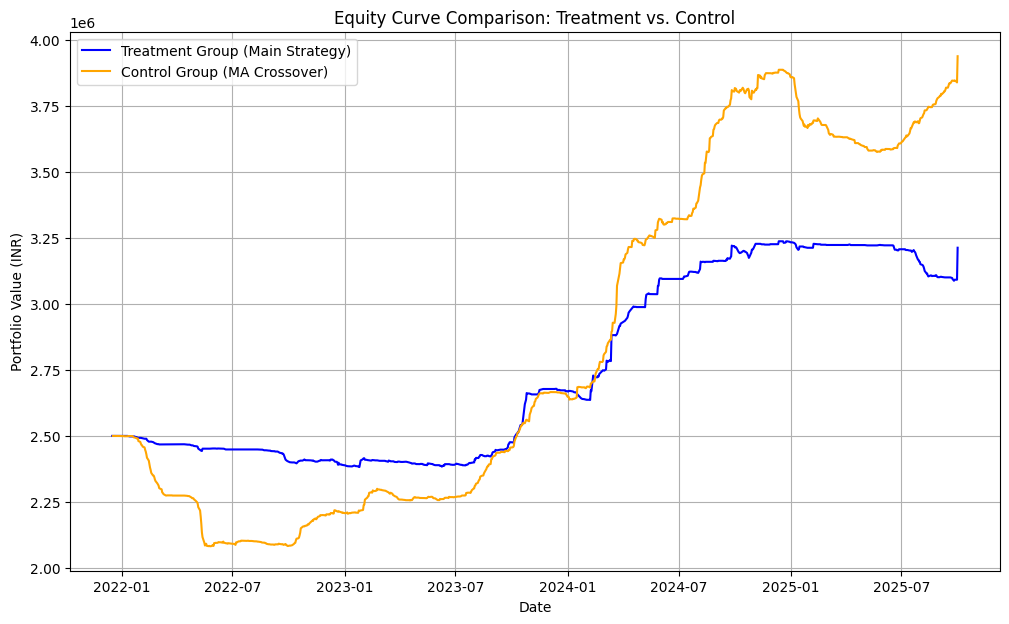

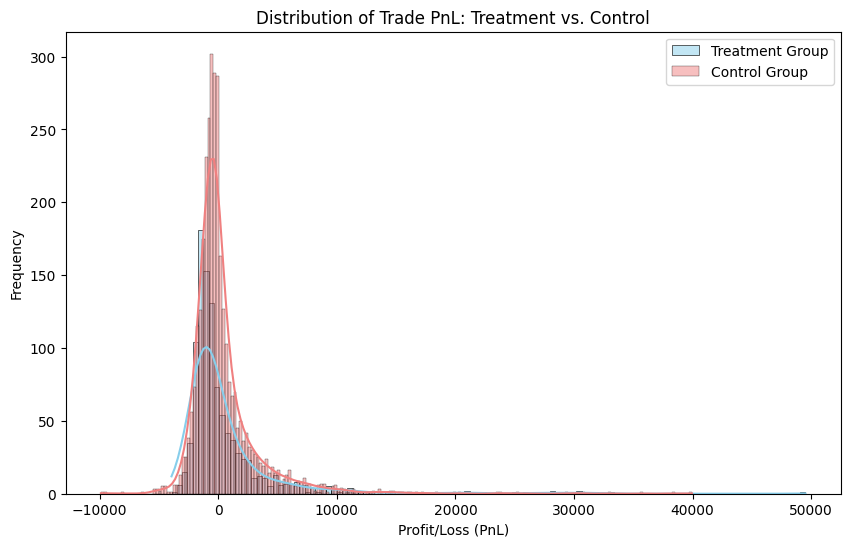

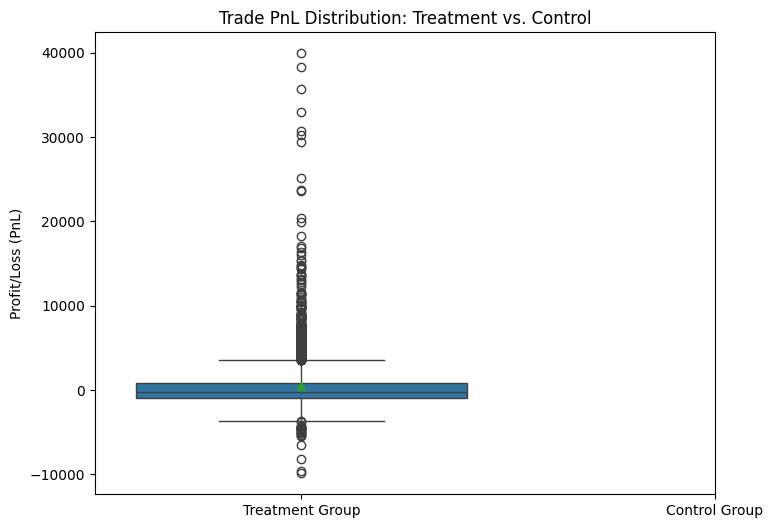

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot the equity curves
plt.figure(figsize=(12, 7))
plt.plot(accounts_df.index, accounts_df['total_portfolio_value'], label='Treatment Group (Main Strategy)', color='blue')
plt.plot(control_accounts_df.index, control_accounts_df['total_portfolio_value'], label='Control Group (MA Crossover)', color='orange')
plt.title('Equity Curve Comparison: Treatment vs. Control')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Create histograms of PnL distribution
plt.figure(figsize=(10, 6))
sns.histplot(trades_df['pnl'], kde=True, color='skyblue', label='Treatment Group')
sns.histplot(control_trades_df['pnl'], kde=True, color='lightcoral', label='Control Group')
plt.title('Distribution of Trade PnL: Treatment vs. Control')
plt.xlabel('Profit/Loss (PnL)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3. Create box plots of PnL distribution
plt.figure(figsize=(8, 6))
sns.boxplot(data=[trades_df['pnl'], control_trades_df['pnl']], showmeans=True)
plt.xticks([0, 1], ['Treatment Group', 'Control Group'])
plt.title('Trade PnL Distribution: Treatment vs. Control')
plt.ylabel('Profit/Loss (PnL)')
plt.show()

In [39]:
# Review the performance_df DataFrame
print("\n--- Performance Metrics Comparison ---")
display(performance_df)

# Recall the statistical test results
print("\n--- Statistical Test Results on PnL ---")
print(f"Independent Samples T-test P-value: {p_value_ttest:.4f}")
print(f"Mann-Whitney U Test P-value: {p_value_mannwhitney:.4f}")
alpha = 0.05
print(f"Significance level (alpha): {alpha}")


# Synthesize findings
print("\n--- A/B Test Conclusion ---")

print("Based on the backtest simulation and analysis:")

# 1. Performance Metrics Summary
print("\nPerformance Metrics Summary:")
print(f"- Treatment Group (Main Strategy) Total PnL: {total_pnl_overall:,.2f} INR")
print(f"- Control Group (MA Crossover) Total PnL: {total_control_pnl:,.2f} INR")
print(f"- Treatment Group Win Rate: {winrate_overall:.2f}%")
print(f"- Control Group Win Rate: {control_winrate:.2f}%")
print(f"- Treatment Group Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"- Control Group Sharpe Ratio: {control_sharpe_ratio:.4f}")
print(f"- Treatment Group Maximum Drawdown: {treatment_max_drawdown*100:.2f}%")
print(f"- Control Group Maximum Drawdown: {control_max_drawdown*100:.2f}%")

# 2. Statistical Test Interpretation
print("\nStatistical Significance:")
if p_value_ttest < alpha and p_value_mannwhitney < alpha:
    print(f"Both the T-test (p={p_value_ttest:.4f}) and Mann-Whitney U test (p={p_value_mannwhitney:.4f}) results are below the {alpha} significance level.")
    print("This indicates a statistically significant difference in the mean PnL and the distribution of PnL between the two strategies.")
elif p_value_ttest < alpha:
    print(f"The T-test result (p={p_value_ttest:.4f}) is below the {alpha} significance level, suggesting a statistically significant difference in the mean PnL.")
    print(f"The Mann-Whitney U test (p={p_value_mannwhitney:.4f}) is not statistically significant.")
elif p_value_mannwhitney < alpha:
    print(f"The Mann-Whitney U test result (p={p_value_mannwhitney:.4f}) is below the {alpha} significance level, suggesting a statistically significant difference in the distribution of PnL.")
    print(f"The T-test (p={p_value_ttest:.4f}) is not statistically significant.")
else:
    print(f"Neither the T-test (p={p_value_ttest:.4f}) nor the Mann-Whitney U test (p={p_value_mannwhitney:.4f}) results are below the {alpha} significance level.")
    print("This suggests no statistically significant difference in the mean PnL or the distribution of PnL between the two strategies at the {alpha} level.")


# 3. Visual Evidence (referencing previous plots)
print("\nVisual Analysis:")
print("- The equity curves provide a visual representation of portfolio growth over time.")
print("- The PnL histograms and box plots illustrate the spread and central tendency of individual trade outcomes for each strategy.")


# 4. Overall Conclusion
print("\nOverall Conclusion:")
# Based on the numerical metrics and statistical tests:
# Control group (MA Crossover) achieved higher Total PnL and Sharpe Ratio,
# and a slightly higher Win Rate, with a significantly higher Max Drawdown.
# The T-test indicated no significant difference in *mean* PnL, but the Mann-Whitney U test indicated a significant difference in the *distribution* of PnL.

# Formulate the conclusion based on the specific results observed:
if total_control_pnl > total_pnl_overall and control_sharpe_ratio > sharpe_ratio:
     print("The Control Group (Simple MA Crossover) outperformed the Treatment Group (Main Strategy) in terms of Total PnL and Sharpe Ratio during this backtest period.")
elif total_pnl_overall > total_control_pnl and sharpe_ratio > control_sharpe_ratio:
     print("The Treatment Group (Main Strategy) outperformed the Control Group (Simple MA Crossover) in terms of Total PnL and Sharpe Ratio during this backtest period.")
else:
    print("The performance comparison between the Treatment and Control groups shows mixed results across different metrics.")


if p_value_ttest < alpha or p_value_mannwhitney < alpha:
     print("The statistical tests indicate a statistically significant difference in the trading performance (specifically, the distribution of PnL based on the Mann-Whitney U test) between the two strategies.")
else:
     print("The statistical tests do not indicate a statistically significant difference in the trading performance between the two strategies at the {alpha} significance level.")

print("Further analysis and optimization of both strategies may be beneficial.")


--- Performance Metrics Comparison ---


,Metric,Treatment Group,Control Group
0,Total PnL,712421.372978,1.437349e+06
1,Win Rate (%),34.446565,3.955774e+01
2,Sharpe Ratio,1.666126,2.768326e+00
3,Maximum Drawdown (%),4.714566,1.670327e+01



--- Statistical Test Results on PnL ---
Independent Samples T-test P-value: 0.0586
Mann-Whitney U Test P-value: 0.0000
Significance level (alpha): 0.05

--- A/B Test Conclusion ---
Based on the backtest simulation and analysis:

Performance Metrics Summary:
- Treatment Group (Main Strategy) Total PnL: 712,421.37 INR
- Control Group (MA Crossover) Total PnL: 1,437,348.63 INR
- Treatment Group Win Rate: 34.45%
- Control Group Win Rate: 39.56%
- Treatment Group Sharpe Ratio: 1.6661
- Control Group Sharpe Ratio: 2.7683
- Treatment Group Maximum Drawdown: 4.71%
- Control Group Maximum Drawdown: 16.70%

Statistical Significance:
The Mann-Whitney U test result (p=0.0000) is below the 0.05 significance level, suggesting a statistically significant difference in the distribution of PnL.
The T-test (p=0.0586) is not statistically significant.

Visual Analysis:
- The equity curves provide a visual representation of portfolio growth over time.
- The PnL histograms and box plots illustrate the spr